# Autoencoder
In this notebook, we are going to be focusing on the variational autoencoder trainer in autoencoder module in PAI-Utils.

## Setup
To begin, we need to import packages and get the Shapes3D dataset.

### Import Packages

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow import keras
import matplotlib.pyplot as plt
from IPython.display import Image, display

from paiutils import image
from paiutils.analytics import Analyzer
from paiutils import neural_network as nn
from paiutils import autoencoder as ae

# see if using GPU and if so enable memory growth
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Get Shapes3D Dataset
1. Download the dataset
2. Discard the labels, and resize and scale the images
3. Partition data into train and validation data
4. Batch the datasets and create a dictionary of the data

In [2]:
# Get dataset
shapes3d = tfds.image.Shapes3d()
shapes3d.download_and_prepare()
print(shapes3d.info.features)
print(shapes3d.info.splits)
data = shapes3d.as_dataset()['train']

# Preprocess dataset
def preprocess(x):
    # resizing for computational efficiency
    x = tf.image.resize(
        x['image'], (32, 32),
        method=tf.image.ResizeMethod.AREA
    )
    x = tf.cast(x, tf.float32) / 255.0
    return x, x
data = data.map(preprocess)

# Split data
data_len = len(data)
data.shuffle(data_len)
val_len = int(data_len * .1)
val_data = data.take(val_len)
train_data = data.skip(val_len)

batch_size = 32
data = {'train': train_data.repeat().batch(batch_size),
        'validation': val_data.batch(batch_size)}
shape = train_data.element_spec[0].shape

FeaturesDict({
    'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
    'label_floor_hue': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    'label_object_hue': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    'label_orientation': ClassLabel(shape=(), dtype=tf.int64, num_classes=15),
    'label_scale': ClassLabel(shape=(), dtype=tf.int64, num_classes=8),
    'label_shape': ClassLabel(shape=(), dtype=tf.int64, num_classes=4),
    'label_wall_hue': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    'value_floor_hue': tf.float32,
    'value_object_hue': tf.float32,
    'value_orientation': tf.float32,
    'value_scale': tf.float32,
    'value_shape': tf.float32,
    'value_wall_hue': tf.float32,
})
{'train': <tfds.core.SplitInfo num_examples=480000>}


## Create the Model
We will now make an encoder model for encoding the image and a decoder model for decoding the encoding. We do not actually have to make the full autoencoder model as the autoencoder trainer will combine the models for us.

In [3]:
latent_dim = 6
x0 = keras.layers.Input(shape=shape)
x = nn.conv2d(64, 3, 2)(x0)
x = nn.conv2d(128, 3, 2)(x)
x = nn.conv2d(256, 3, 2)(x)
x = nn.conv2d(512, 3, 2)(x)
x = keras.layers.Flatten()(x)
z_mean = keras.layers.Dense(latent_dim)(x)
z_log_var = keras.layers.Dense(latent_dim)(x)
z_log_var = keras.layers.Lambda(
    lambda x: tf.clip_by_value(x, -50, 50)  # helps to avoid NaN
)(z_log_var)
encoder_model = keras.Model(inputs=x0, outputs=[z_mean, z_log_var])
encoder_model.compile(optimizer='adam', loss='mse')
encoder_model.summary()

x0 = keras.layers.Input(shape=(latent_dim,))
x = nn.dense(2048)(x0)
x = keras.layers.Reshape((2, 2, 512))(x)
x = nn.conv2d(512, 3, 2, transpose=True)(x)
x = nn.conv2d(256, 3, 2, transpose=True)(x)
x = nn.conv2d(128, 3, 2, transpose=True)(x)
x = nn.conv2d(64, 3, 2, transpose=True)(x)
# We will enable use_logits for the model so it will apply sigmoid
# after this output. However, we must remeber when we use the decoder
# we need to apply a sigmoid on the output before viewing the output.
output = nn.conv2d(3, 1, 1, activation='linear', batch_norm=False)(x)
decoder_model = keras.Model(inputs=x0, outputs=output)
decoder_model.compile(optimizer=keras.optimizers.Adam(.0001), loss='binary_crossentropy')
decoder_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   1728        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 8, 8, 128)    73728       batch_normalization[0][0]        
_______________________________________________________________________________________

## Train the Model
We can now use the VAETrainer to train the encoder and decoder models on the dataset.

In [4]:
steps_per_epoch = int(len(train_data) // batch_size)
trainer = ae.VAETrainer(
    encoder_model, decoder_model, data,
    rloss_coef=1000, use_logits=True
)
trainer.train(10, steps_per_epoch=steps_per_epoch)
path = trainer.save('')

Epoch 1/10
13500/13500 [==============================] - 162s 12ms/step - loss: 323.4512 - reconstruction_loss: 0.3191 - divergence_loss: 4.3261 - val_loss: 0.3020
Epoch 2/10
13500/13500 [==============================] - 162s 12ms/step - loss: 305.3658 - reconstruction_loss: 0.3016 - divergence_loss: 3.7829 - val_loss: 0.2983
Epoch 3/10
13500/13500 [==============================] - 162s 12ms/step - loss: 301.5769 - reconstruction_loss: 0.2979 - divergence_loss: 3.6941 - val_loss: 0.2980
Epoch 4/10
13500/13500 [==============================] - 161s 12ms/step - loss: 299.7248 - reconstruction_loss: 0.2961 - divergence_loss: 3.6476 - val_loss: 0.2961
Epoch 5/10
13500/13500 [==============================] - 166s 12ms/step - loss: 298.5559 - reconstruction_loss: 0.2949 - divergence_loss: 3.6332 - val_loss: 0.2967
Epoch 6/10
13500/13500 [==============================] - 161s 12ms/step - loss: 297.7846 - reconstruction_loss: 0.2942 - divergence_loss: 3.6080 - val_loss: 0.2953 - - ETA: 6

## Evaluate the Model
Before testing the model, we can evaluate the model by getting losses for the train and validation data. It's important to note that these losses are only calculated with the reconstruction loss function.

In [5]:
print(trainer.eval(batch_size=100))

Train Data Evaluation: 
100/100 [==============================] - 1s 5ms/step - loss: 0.2959
Validation Data Evaluation: 
100/100 [==============================] - 1s 5ms/step - loss: 0.2951
{'Train': 0.2959277927875519, 'Validation': 0.29507437348365784}


## Test the Full Model
The model is now trained and saved, so we can test the full model by using the AutoencoderPredictor to load the saved model and weights.

### Load Predictor

In [6]:
#path = 'trained_model3'
predictor = ae.AutoencoderPredictor(path)

### Display Comparisions

Using the predictor, we can display input images on the left and reconstructed images on the right.

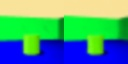

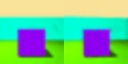

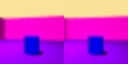

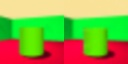

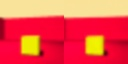

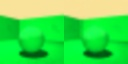

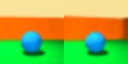

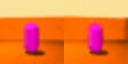

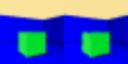

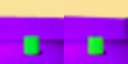

In [7]:
%matplotlib inline
example_data = val_data.take(10)
for example in example_data:
    example = example[0].numpy()
    pred = predictor.predict(example) * 255.0
    pred = pred.astype('uint8')
    example = (example * 255.0).astype('uint8')
    ret = image.cv2.imencode('.jpg', np.hstack([image.pyr(example, 1),
                                                image.pyr(pred, 1)]))[1]
    display(Image(data=ret))

## Test the Decoder

The model reconstructs the input images well, but let us now look at generating images.

### Find Variable Ranges

Before we generate images, we will create a boxplot for each of the means and variances. The boxplots will help us understand the valid range of the variables for when we use the decoder.

#### Load Encoder

In [8]:
encoder = ae.AutoencoderPredictor(path, uses_encoder_model=True)

#### Display Boxplots

[ 0.03957913 -0.04371828  0.01230285 -0.01895366 -0.02975563 -0.05662525]
[1.2601864 1.2094115 1.2253221 1.2587758 1.2092351 1.2223942]
means


<IPython.core.display.Javascript object>


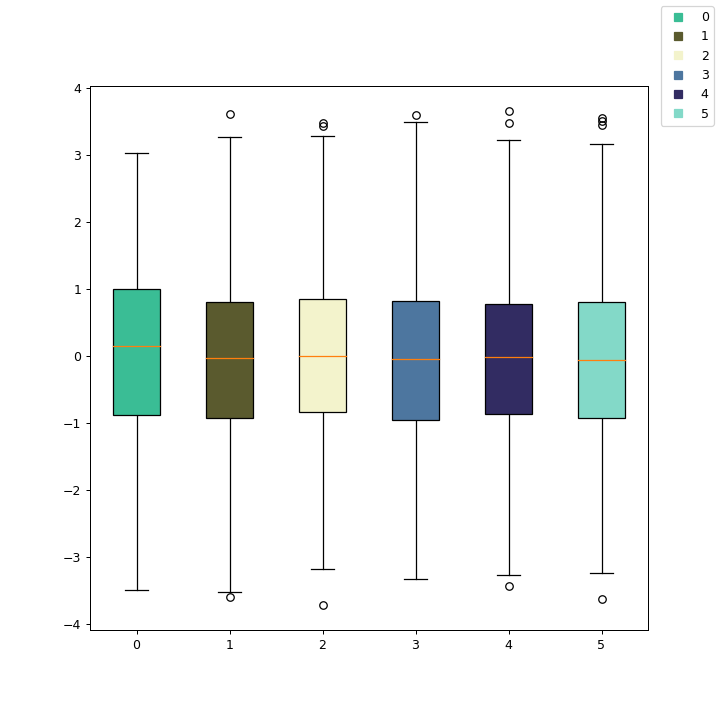

variances


<IPython.core.display.Javascript object>


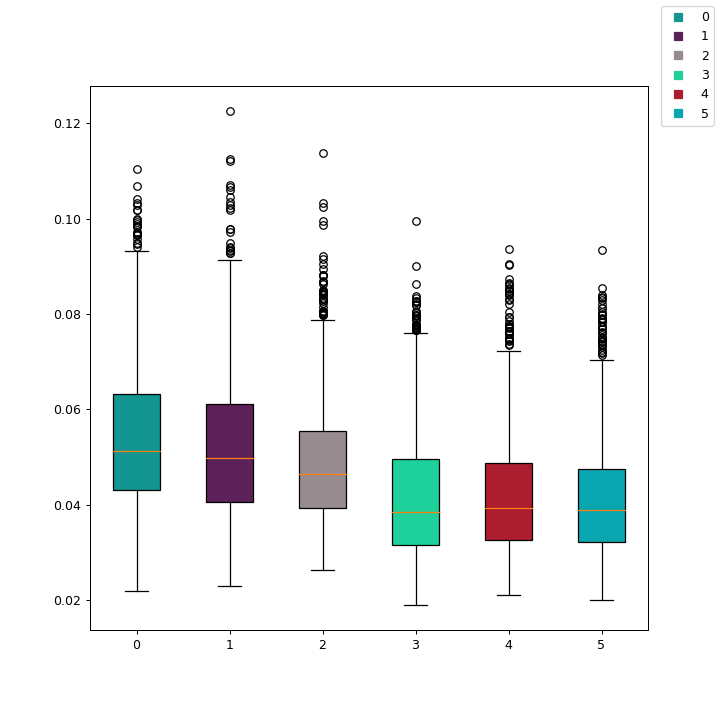

In [9]:
%matplotlib notebook

sample_size = 1000

# Predictor/Analyzer only works with ndarrays
# so converting dataset in to ndarray
np_train_data = train_data.batch(
    sample_size
).as_numpy_iterator().next()[0]

# Get means and log vars of the sampled data
means, logvars = encoder.predict_all(np_train_data)
variances = np.exp(logvars * .5)

# Get means of the means and
# std dev. of means (will use later)
mean_means = means.mean(axis=0)
mean_stds = means.std(axis=0)
print(mean_means)
print(mean_stds)

# Convert means and logvars to useable
# format for plotting with the Analyzer
means = means.flatten()
variances = variances.flatten()
y_means = np.tile(np.arange(latent_dim), sample_size)
y_vars = np.tile(np.arange(latent_dim), sample_size)

# Create Analyzers
mean_analyzer = Analyzer(means, y_means, list(range(latent_dim)))
var_analyzer = Analyzer(variances, y_vars, list(range(latent_dim)))

# Visualize the encodings
print('means')
_ = mean_analyzer.boxplot(means)
print('variances')
_ = var_analyzer.boxplot(variances)

### Generate Images

We now have an idea of the variable ranges, so let us generate a grid of images.

#### Load Decoder

In [10]:
decoder = ae.AutoencoderPredictor(path, uses_decoder_model=True)

#### Display Grid of Generated Images

We will now create and display a grid of generated images with the the first two variables being stepped and the other variables being taken from a normal distribution. 

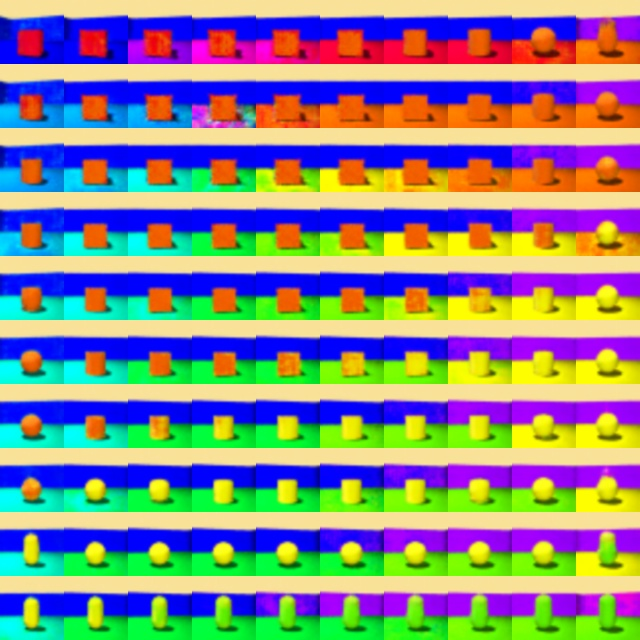

In [11]:
scale = int(2)
size = 32 * scale
steps = 10

# Index of the variable in Z that
# an axis represents
xaxis = 0
yaxis = 1

norm = tfp.distributions.Normal(mean_means[xaxis],
                                mean_stds[xaxis])
grid_x = norm.quantile(np.linspace(0.05, 0.95, steps))
norm = tfp.distributions.Normal(mean_means[yaxis],
                                mean_stds[yaxis])
grid_y = norm.quantile(np.linspace(0.05, 0.95, steps))

grid = np.empty((size * steps,
                 size * steps, 3))
for _ in range(1):
    z = np.random.normal(0, 1, size=latent_dim)
    z = z * mean_stds + mean_means
    for i, y in enumerate(grid_y):
        for j, x in enumerate(grid_x):
            z[xaxis] = x
            z[yaxis] = y
            decoded = decoder.predict(z)
            decoded = tf.math.sigmoid(decoded)
            grid[i * size: (i + 1) * size,
                 j * size: (j + 1) * size] = image.pyr(decoded.numpy(), scale - 1)

    ret = image.cv2.imencode('.jpg', (grid * 255).astype('uint8'))[1]
    display(Image(data=ret))

As we can see, the variables we stepped through adjusted multiple aspects of the image. We were able to create some unique shapes that did not exist in the training dataset, which look like a combination of a capsule and sphere.